In [3]:
source("tstmle.R")
library(glue)
library(rje)
library(data.table)
library(doParallel)

origami v1.0.7: Generalized Framework for Cross-Validation


Attaching package: 'data.table'


The following object is masked from 'package:rje':

    last


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



<h1>Simulation 1: Average over time of context-specific causal effects of single time time point intervention</h1>

$$
\Psi^N(P^N) = \frac{1}{N}\sum_{t=1}^N\{\mathbb{E}(Y(t)|A(t)=1, c_o(t)) - \mathbb{E}(Y(t)|A(t)=0, c_o(t))\}
$$

In [5]:
N <- 100
monte_carlo_draws <- 500
folder <- "simulation_data"

<h3>Simulation 1a (simple dependence)</h3>

Binary Treatment and Outcome, with dependence of Markov order 2.
We observe 3 covariates, $W_1(t),W_2(t),W_3(t)$. The first and third are drawn from a bernoulli distribution and the second from a discrete uniform distribution.

We let $A(t)$ be a be function of $W_1(t-1),W_2(t-1),Y(t-1),A(t-1)$ and $W_3(t-2)$
$Y(t)$ also exhibts dependence of order $2$, $W_1(t-1),W_2(t-1),W_3(t-1),A(t), W_1(t-2),W_3(t-2)$.

$$A(0:4) \sim \text{Bern}(0.5) $$
$$Y(0:4) \sim \text{Bern}(0.5) $$
$$W_1(0:n) \sim \text{Bern}(0.5) $$
$$W_2(0:n) \sim \text{Unif}(1,3) $$
$$W_3(0:n) \sim \text{Bern}(0.5) $$

$$A(4:n) \sim \text{Bern}(\text{expit}(0.25 * W_1(t-1) - 0.2 *W_2(t-1) \\+ 0.3 * Y(t-1) - 0.2 * A(t-1) \\ + 0.2 * W_3(t-2))) $$
$$Y(4:n) \sim \text{Bern}(\text{expit}(0.3 - 0.8 * W_1(t-1) + 0.1 *W_2(t-1) \\ + 0.2 * W_3(t-1) + A(t) - 0.5 * W_1(t-2) \\ + 0.2 * W_3(t-2))) $$

What is the expected Average Treatment Effect for this defined process? I'm unsure if there's a way one can explicitly calculate it from the system of equations. But running the proccess for a extremely large N, and manually calculated the difference in probabilities (for either A equal to 1 or 0) of Y at every row I got $\text{ATE}\approx0.218$

In [9]:
simulation_1a_true_ATE <- 0.218

In [5]:
simulation_1a <- function(){
    # Using rbinom(_, 1, _) seems easiest way to get the behaviour of a bernoulli trial 
    W <- data.frame(
        "W1" = rbinom(N, 1, 0.5),
        "W2" = ceiling(runif(N, 0, 3)), # Equivalent to uniform 1 to 3
        "W3" = rbinom(N, 1, 0.5)
    )

    A <- numeric(N)
    Y <- numeric(N)
    A[1:4] <- rbinom(4, 1, 0.5)
    Y[1:4] <- rbinom(4, 1, 0.5)


    # W[i, j] <- i'th row, j'th column
    for(i in 5:N){
        p <- expit(0.25*W[(i-1), 1] - 0.2*W[(i-1), 2] + 0.3*Y[(i-1)] 
            - 0.2*A[(i-1)] + 0.2*W[(i-2), 3]
        )
        A[i] <- rbinom(1, 1, p)
        p <- expit(0.3 - 0.8*W[(i-1), 1] + 0.1*W[(i-1), 2] + 0.2*W[(i-1),3] 
            + A[i] - 0.5*W[(i-2), 1] + 0.2*W[(i-2), 3]
        )
        Y[i] <- rbinom(1, 1, p)
    }

    data <- cbind(W,A,Y)
    return(data)
}

In [28]:
source("tstmle.R")

file <- glue("{folder}/simulation1a_MC{monte_carlo_draws}_N{N}.rds")

node_list <- list(
    W = c("W1", "W2", "W3"),
    A = "A",
    Y = "Y"
)
ate_spec <- tmle_ATE(treatment_level = 1, control_level=0)

tmle_fits <- data.table()

# nworkers <- detectCores()
# cl <- makePSOCKcluster(nworkers)
# registerDoParallel(cl)

# for (i in 1:monte_carlo_draws){
#     draw <- simulation_1a()
#     tmle_fit <- run_tstmle(ate_spec, draw, node_list, markov_order=3)
#     tmle_fits <- rbind(tmle_fits, tmle_fit$summary)
# }

# tmle_fits <- foreach(i = 1:monte_carlo_draws, .combine='rbind', .packages=c("rje","sl3","origami","tmle3")) %dopar% {
#     draw <- simulation_1a()
#     tmle_fit <- run_tstmle(ate_spec, draw, node_list, markov_order=3)
#     tmle_fit$summary
# }

#saveRDS(tmle_fits, file)

In [29]:
mean(simulation_1a()$"Y")

[1] 0.69

In [31]:
tmle_fits <- readRDS(file)

In [32]:
head(tmle_fits)

type,param,init_est,tmle_est,se,lower,upper,psi_transformed,lower_transformed,upper_transformed
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATE,ATE[Y_{A=1}-Y_{A=0}],0.29000790,0.3362846,0.08210004,0.1753715325,0.4971978,0.3362846,0.1753715325,0.4971978
ATE,ATE[Y_{A=1}-Y_{A=0}],0.07647541,0.2338892,0.09402554,0.0496024812,0.4181758,0.2338892,0.0496024812,0.4181758
ATE,ATE[Y_{A=1}-Y_{A=0}],0.13384857,0.2263521,0.11530654,0.0003554357,0.4523488,0.2263521,0.0003554357,0.4523488
ATE,ATE[Y_{A=1}-Y_{A=0}],0.13537640,0.2064263,0.09758799,0.0151573449,0.3976952,0.2064263,0.0151573449,0.3976952
ATE,ATE[Y_{A=1}-Y_{A=0}],0.16369402,0.2410985,0.09892506,0.0472089430,0.4349880,0.2410985,0.0472089430,0.4349880
ATE,ATE[Y_{A=1}-Y_{A=0}],0.07928709,0.1884728,0.10649724,-0.0202579931,0.3972035,0.1884728,-0.0202579931,0.3972035


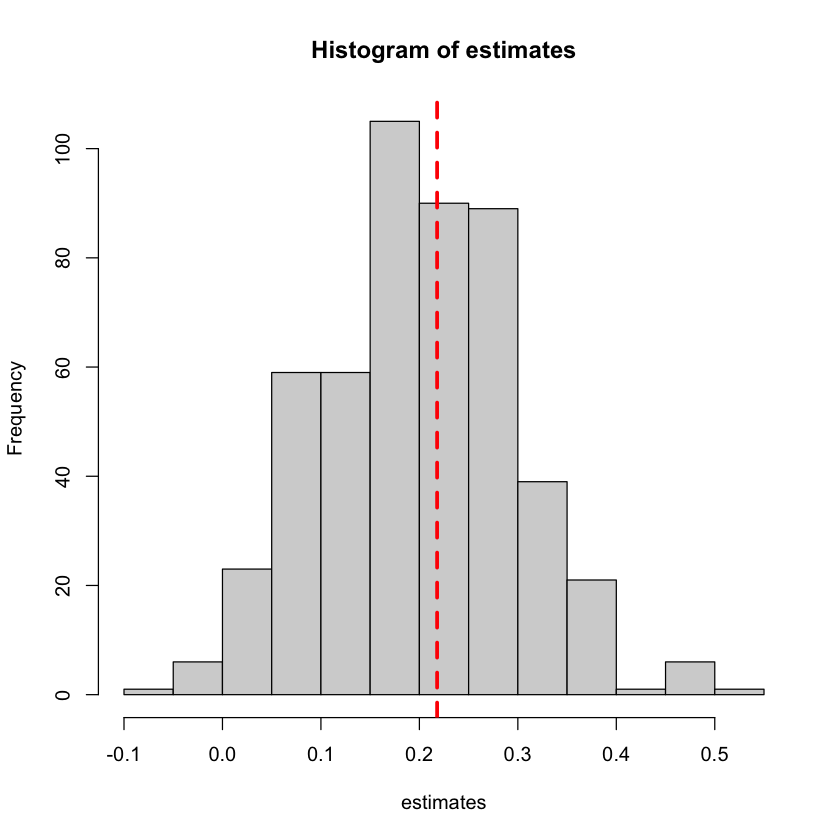

In [33]:
estimates <- tmle_fits$"tmle_est"
hist(estimates)
abline(v = simulation_1a_true_ATE, col='red', lwd = 3, lty = 2)

Variance is just standard error squared?

In [10]:
# In the paper they get a negative bias, but taking the average with using the magnitude of the error seem's fishy?
average_bias <- function(tmle_fits, true_param){
    mean(tmle_fits$"tmle_est" - true_param)
}

average_variance <- function(tmle_fits){
    mean((tmle_fits$"se")^2)
}

coverage <- function(tmle_fits, true_param){
    n <- length(tmle_fits)
    agg <- numeric(n)
    for(i in 1:n){
        lower <- tmle_fits$"lower"[i]
        upper <- tmle_fits$"upper"[i]
        if(lower <= true_param && true_param <= upper){
            agg[i] <- 1
        }
    }
    return(mean(agg))
}

print(average_bias(tmle_fits, simulation_1a_true_ATE))

print(average_variance(tmle_fits))

print(coverage(tmle_fits, simulation_1a_true_ATE))

[1] 0.0719157
[1] 0.001187402
[1] 0.4


<h1>Situation 1c: More Elaborate Dependence</h1>

$$
A(0: 6) \sim \text{Bern}(0.5) \\
Y(0: 6) \sim \text{Bern}(0.5) \\
W_1(0: 6) \sim \text{Bern}(0.5) \\
W_2(0: 6) \sim \text{Normal}(0, 1) \\

A(6 : n) \sim \text{Bern}\bigg(\text{expit}\big(0.7 * W_1(t-2) - 0.3*A(t-1) + 0.2 * sin(W_t(t-2) * A(t-3))\big)\bigg) \\
 
Y(6 : n) \sim \text{Bern}\bigg(\text{expit}\big(1.5 * A(t) - (W_1(t-1) * A(t-2))^2 + 0.9 * sin(W_2(t-4))*A(t-3)*cos(W_2(t-6)) - abs(W_2(t-5)>0)\big)\bigg) \\

W_1(6:n) \sim \text{Bern}(\text{expit}(0.5 * W_1(t-1) - 0.5 * Y(t-1) + 0.1*W_2(t-1)))\\

W_2(6: n) \sim \text{Normal}(0.6 * A(t-1)+Y(t-1)-W_1(t-1), 1) 
$$

In [1]:
simulation_1c_true_ATE <- 0.279

In [18]:
simulation_1c <- function(){
    # Using rbinom(_, 1, _) seems easiest way to get the behaviour of a bernoulli trial 
    W1 <- numeric(N)
    W2 <- numeric(N)

    W1[1:6] <- rbinom(6, 1, 0.5)
    W2[1:6] <- rnorm(6, 0, 1)

    A <- numeric(N)
    Y <- numeric(N)
    A[1:6] <- rbinom(6, 1, 0.5)
    Y[1:6] <- rbinom(6, 1, 0.5)

    diff <- numeric(N)
    # W[i, j] <- i'th row, j'th column
    for(i in 7:N){
        p <- expit(0.5*W1[(i-1)] - 0.5*Y[(i-1)] + 0.1*W2[i-1])
        W1[i] <- rbinom(1, 1, p)

        mu <- 0.6 * A[i-1] + Y[i-1] - W1[i-1]
        W2[i] <- rnorm(1, mu, 1)

        p <- expit( 0.7 * W1[i-2] - 0.3*A[i-1] + 0.2 * sin(W1[i-2] * A[i-3]))
        A[i] <- rbinom(1, 1, p)
        p <- expit(1.5 * A[i] - (W1[i-1] * A[i-2])^2 + 0.9 * sin(W2[i-4])*A[i-3]*cos(W2[i-6]) - abs(W2[i-5]))
        Y[i] <- rbinom(1, 1, p)
    }

    data <- data.frame(W1,W2,A,Y)
    return(data)
}

simulation_1c()

W1,W2,A,Y
1,-0.37115787,1,1
1,-0.75948196,1,0
1,-0.61553112,1,1
1,-0.30651393,0,1
0,-0.24069269,0,0
0,0.78495407,1,0
1,-1.23971882,1,0
0,-0.17256339,1,1
1,2.88546380,1,1
1,1.04875218,1,1


In [11]:
monte_carlo_draws <- 500
N <- 500

file <- glue("{folder}/simulation1c_MC{monte_carlo_draws}_N{N}.rds")

node_list <- list(
    W = c("W1", "W2"),
    A = "A",
    Y = "Y"
)
ate_spec <- tmle_ATE(treatment_level = 1, control_level=0)

tmle_fits <- data.table()

# for (i in 1:monte_carlo_draws){
#     draw <- simulation_1c()
#     tmle_fit <- run_tstmle(ate_spec, draw, node_list, markov_order=6)
#     tmle_fits <- rbind(tmle_fits, tmle_fit$summary)
# }
# saveRDS(tmle_fits, file)

In [12]:
tmle_fits <- readRDS(file)

print(average_bias(tmle_fits, simulation_1c_true_ATE))

print(average_variance(tmle_fits))

print(coverage(tmle_fits, simulation_1c_true_ATE))

[1] 0.0109157
[1] 0.001187402
[1] 0.8


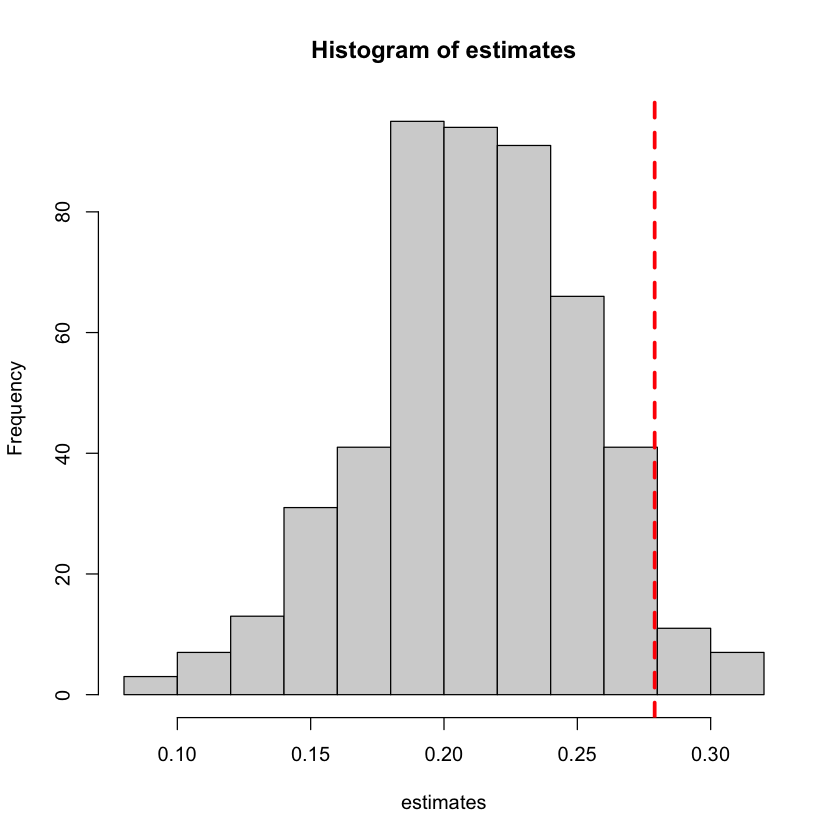

In [101]:
estimates <- tmle_fits$"tmle_est"
hist(estimates)
abline(v = simulation_1c_true_ATE, col='red', lwd = 3, lty=2)